# CCD spectrometer
* ## Background
* ## Ethanol

All counts are transformed to rates. 
Background is then subtracted. 

Errors are taken to be the statistical ones: $s_N = \frac{\sqrt{N}}{\sqrt{n}}$, where N is the number of counts and n the number of measurements that have been measured over.

The xlim for plotting is set globally.

In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [66]:
import re
from scipy.constants import c,h,eV, pi
hceV = h * c  /eV
find_number = lambda string: re.search("-?\\d+",string).group(0)

from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
        fig_dir = "../figures/"
        npy_dir = "./npy/"
        
xlim_global = (420, 620)
colors = ['b', 'r', 'g', 'darkmagenta', 'firebrick', 'cyan', 'orange', 'magenta', 'darkgoldenrod']

In [61]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
   
def bw_fit(x, y, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

def double_breit_wigner(x, x0, gamma, amplitude, x0_2, gamma_2, amplitude_2, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    f_x = amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + \
        amplitude_2 / ((pi*gamma_2) * (1 + ((x - x0_2) / gamma_2)**2)) + \
        offset
    return(f_x)
    
def double_bw_fit(x, y, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(double_breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = double_breit_wigner(x_fit, *coeff)
    else:
        fit_peak = double_breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

def poly(x, p0, p1, p2, p3, p4):
    return p0*x**4 + p1*x**3 + p2*x**2 + p3*x + p4

def poly_fit(x, y, y_e, x_range, p0):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))

    coeff, cov = curve_fit(poly, x_fit, y_fit, p0=p0, 
                           sigma=y_sigma, absolute_sigma=True)
    c = uc.correlated_values(coeff, cov)
    return c

In [21]:
def uc_str(c):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max 4 error digits
    as floats with max 3 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < 4): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

In [22]:
def t_avg(filename):
    """
    Get integration time and number of measurements
    """
    f = open("data/" + filename + ".txt", encoding='cp1252')
    lines = f.readlines()
    f.close()
    t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
    avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from
    return t, avg

## Background

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


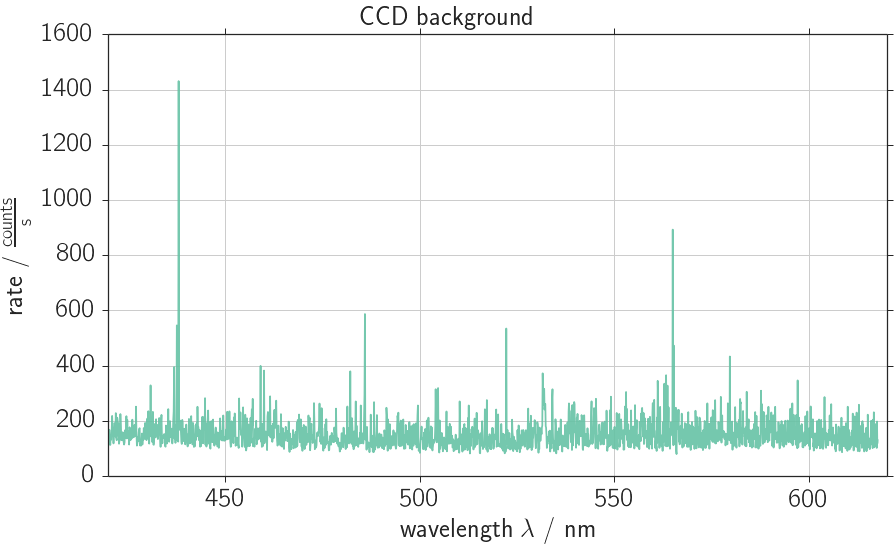

In [23]:
#### Background ####
filename = "ccd_bg_30_10"

# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))

rate_bg = y / t
rate_bg_e = y_e / t

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD background')
ax.plot(x, rate_bg, "-", alpha = 0.9)
ax.set_xlim(xlim_global)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
#ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_background"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Ethanol
* Get data
* Remove outliers (errors from CCD)
* Fit flourescence for lambda > 550 nm with 3rd degree polynome, omitting the peaks
* Fit peaks on data - flourescence 

Peak intensities are saved to 'As' (A = integral over breit_wigner). Only the single peaks are used. The double peak could be used for higher concentrations (>= 40% ethanol), but fits dont converge for lower ones. 
Luckily, the intensities do seem to make sense (although flourescence indicates something different - the latter may be a result of impurities in the original sample). 

# Missing: Demostration of removing the outliers...

0
1
2
3
4
5
6
7
8


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


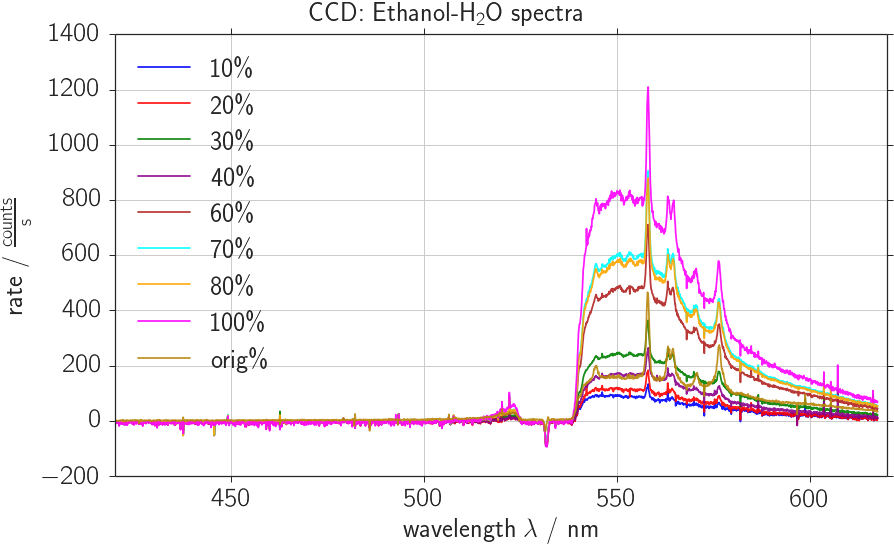

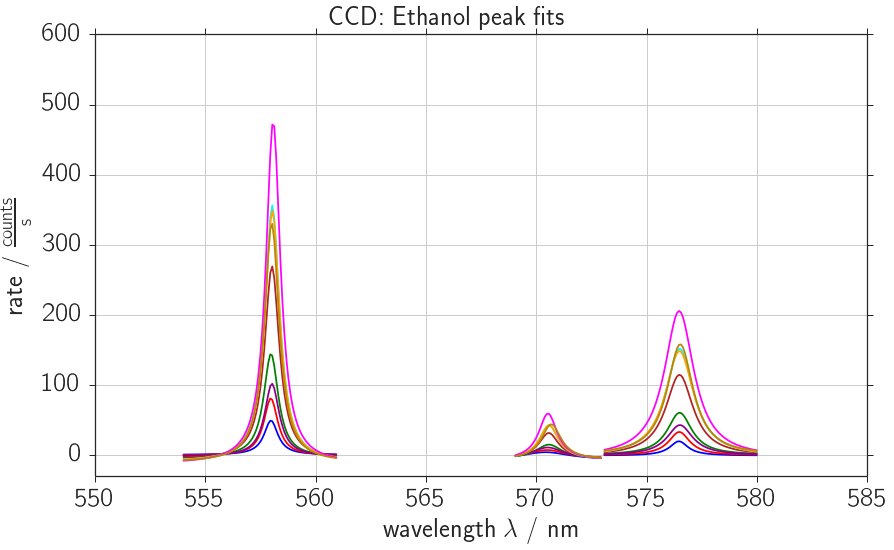

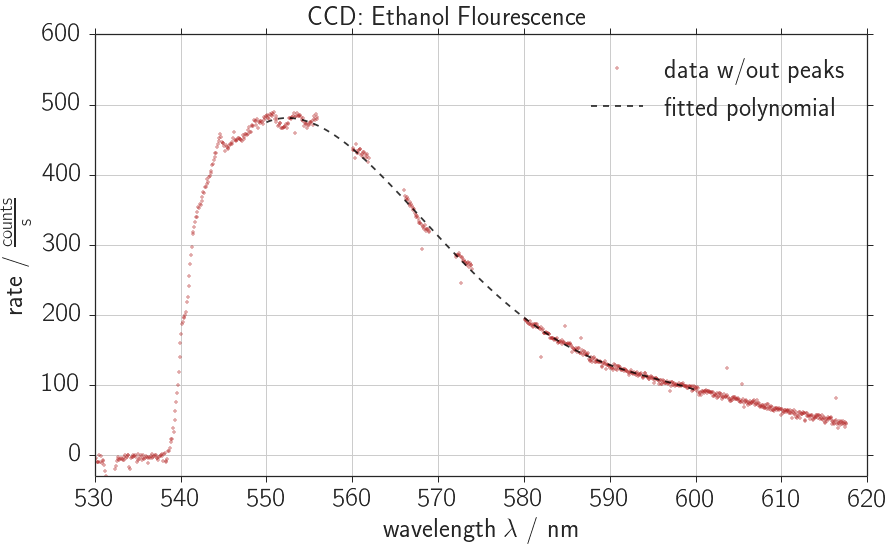

In [77]:
# 0 % not usable (of course)
concentration = [10, 20, 30, 40, 60, 70, 80, 100, 'orig']
#concentration = [40, 'orig']
As = []

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: Ethanol-H$_2$O spectra')
    
fig2, ax2 = plt.subplots(1,1)
if not save_fig:
    fig2.suptitle('CCD: Ethanol peak fits')
    
    
#### Ethanol ####
for i, conc_i in enumerate(concentration):
    print(i)
    filename = "ccd_et_" + str(conc_i)
    t, avg = t_avg(filename)
    
    # Data
    x = np.load("npy/"+filename+"_lamb.npy")
    y = np.load("npy/"+filename+"_count.npy")
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))
    y = y / t - rate_bg
    y_e = y_e / t - rate_bg_e
    
    # Remove outliers 
    # identified by largest absolute value of difference between point and its two neighbours.
    for j in range(4):
        out = np.argmax(abs(2 * y[1:-1] - y[:-2] - y[2:])) + 1
        #print(x[out], y[out])
        x, y = np.delete([x, y], out, 1)
        y_e = np.delete(y_e, out)
    data_points, = ax.plot(x, y, "-", alpha = 0.9, c=colors[i], label=str(conc_i) + '\%')

    # Flourescence: fit for 550 - 590 nm w/out peaks
    x_peaks = np.array([[556, 560], [562, 566], [569, 572], [574, 580]])
    where_peaks = [(x_low < x) * (x < x_high) for x_low, x_high in x_peaks]
    mask_no_peak = np.where(sum(where_peaks) == 0)[0]
    x_np = x[mask_no_peak]
    y_np = y[mask_no_peak]
    y_np_e = y_e[mask_no_peak]
  
    
    x_range = [550,  600]
    p0 = np.array([0, 0, 0, 0, 0])
    p =  poly_fit(x_np, y_np, y_np_e, x_range, p0)
    p_n = un.nominal_values(p)
    x_poly = np.linspace(x_range[0], x_range[1], 200)
    y_poly = poly(x_poly, *p_n)
    if conc_i == 60:
        fig3, ax3 = plt.subplots(1,1)
        if not save_fig:
            fig3.suptitle('CCD: Ethanol Flourescence')
        ax3.plot(x_np, y_np, ".", alpha = 0.4, label='data w/out peaks', c=data_points.get_color())  
        ax3.plot(x_poly, y_poly, "--", alpha = 0.8, label='fitted polynomial', c='k')#c=data_points.get_color())
        ax3.set_xlim(x_range[0] - 20, x_range[1] + 20)
        #ax3.set_xlim(xlim_global)
        ax3.set_ylim(-30, 600)
        ax3.set_xlabel('wavelength $\lambda$ / nm')
        ax3.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
        ax3.grid(True)
        ax3.legend(loc='best')

    # Peak fit: Data - flourescence
    y_fit = y - poly(x, *p_n)
    y_fit_e = y_e - poly(x, *p)
    #ax.plot(x, y_fit, "-", alpha = 0.6, label=str(conc_i) + '\%')

    x_range1 = [554, 561]   # lower and upper bound
    p0 = np.array([558, 0.2, 100, 0])
    x_fit1, fit_peak1, c1 = bw_fit(x, y_fit, y_fit_e, x_range1, p0, fit=True)
    peak1, = ax2.plot(x_fit1, fit_peak1, "-", c=colors[i], label='558 nm')
    
    """ # double peak does not converge...
    x_range2 = [561, 568]   # lower and upper bound
    p0 = np.array([563, 0.2, 100, 565, 0.2, 100, 0])
    x_fit2, fit_peak2, c2 = double_bw_fit(x, y_fit, y_fit_e, x_range2, p0, fit=True)
    ax2.plot(x_fit2, fit_peak2, "-",  c=peak1.get_color(), label='563.3 \& 564.4 nm')
    """
    
    x_range4 = [569, 573]   # lower and upper bound
    p0 = np.array([571, 0.2, 50, 0])
    x_fit4, fit_peak4, c4 = bw_fit(x, y_fit, y_fit_e, x_range4, p0, fit=True)
    ax2.plot(x_fit4, fit_peak4, "-", c=peak1.get_color(), label='571.5 nm')
    
    x_range5 = [573, 580]   # lower and upper bound
    p0 = np.array([577, 0.2, 50, 0])
    x_fit5, fit_peak5, c5 = bw_fit(x, y_fit, y_fit_e, x_range5, p0, fit=True)
    ax2.plot(x_fit5, fit_peak5, "-", c=peak1.get_color(), label='576.5 nm')
    
    # Collect intensities
    As.append([c_i[2] for c_i in [c1, c4, c5]])

ax.set_xlim(xlim_global)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
ax.legend(loc='best')

ax2.set_xlim(x_range[0], x_range[1] - 15)
ax2.set_ylim(-30, 600)
ax2.set_xlabel('wavelength $\lambda$ / nm')
ax2.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax2.grid(True)
#ax2.legend(loc='best')

if save_fig:
    file_name = "ccd_ethanol_measurements"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")
    file_name = "ccd_ethanol_peak_fits"
    fig2.savefig(fig_dir + file_name + ".pdf")
    fig2.savefig(fig_dir + file_name + ".png")
    file_name = "ccd_ethanol_flourescence"
    fig3.savefig(fig_dir + file_name + ".pdf")
    fig3.savefig(fig_dir + file_name + ".png")

### Linear Fit on ethanol percentage

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


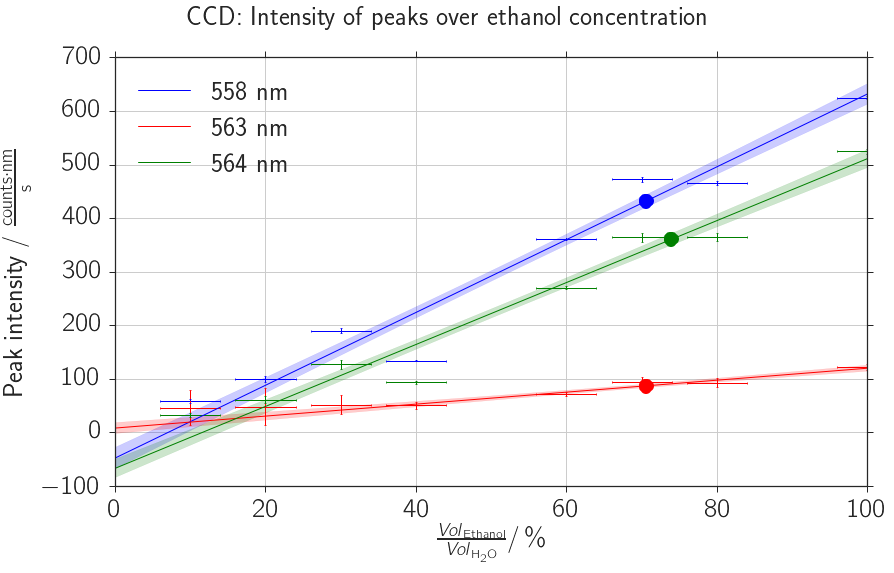

In [40]:
from scipy.odr import ODR, Model, Data, RealData

def func(beta, x):
    y = beta[0] + beta[1] * x
    return y

def linear(x, beta_0, beta_1):
    return beta_0 + beta_1 * x


# Plotting
x_min, x_max = [0, 100]
x_fit = np.linspace(x_min, x_max, 200)
fig, ax = plt.subplots(1, 1)
if not save_fig:
    fig.suptitle('CCD: Intensity of peaks over ethanol concentration', y = 1.02)
    
A_e = np.array(As[:-1]).T # entries of each peak put together
peaks = ['558', '563', '564', '572', '577']
i_s = range(len(A_e))
intersects = []

for i, peak, A in zip(i_s, peaks, A_e):
    y = un.nominal_values(A)
    sy = un.std_devs(A)
    x = np.array(concentration[:-1])
    sx = 4

    data = RealData(x, y, sx=sx, sy=sy)
    model = Model(func)

    odr = ODR(data, model, [6, 0])
    odr.set_job(fit_type=0)
    output = odr.run()

    beta = uc.correlated_values(output.beta, output.cov_beta)
    np.save(npy_dir + 'ccd_et_peak_' + peak, beta)
    
    fit = linear(x_fit, *beta)

    ax.fill_between(x_fit, 
            un.nominal_values(fit) + un.std_devs(fit),
            un.nominal_values(fit) - un.std_devs(fit),
            facecolor=colors[i], color=colors[i], alpha=0.2)
    ax.plot(x_fit, un.nominal_values(fit), '-', c=colors[i], linewidth=1.0, label=peak + ' nm')  
    ax.errorbar(x, y, xerr=sx, yerr=sy, fmt=',', c=colors[i], elinewidth=1.0, capsize=1.2, capthick=0.8)
    
    #Intersects
    y0 = As[-1][i]
    x0 = (y0 - beta[0]) / beta[1]
    intersects.append(x0)
    #ax.plot([x_min, x_max], [As[-1][i].n]*2, '--', c=colors[i])
    ax.plot(x0.n, As[-1][i].n, 'o', c=colors[i], ms=15)
    
ax.set_xlim(x_min, x_max)
ax.set_xlabel("$\\frac{Vol_\mathrm{\,Ethanol}}{Vol_\mathrm{\,H_2O}} / \,\% $")
ax.set_ylabel("Peak intensity / $\mathrm{\\frac{counts \cdot nm}{s}}$")
ax.grid(True)
ax.legend(loc='best')

if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_ethanol_intensity"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

The ethnanol concentration is the mean value of the two intersects. As they are somewhat close together, we can already state that the result is reasonable!

In [32]:
# Ethanol concentration in the unknown original sample.
np.mean(intersects)

71.69494607912884+/-3.2296650491385175